# Collision checking tutorial 💥

This notebook shows how to:
* Set up collision checking for joint configurations
* Apply collision checking to joint and TCP paths

## 1. Creating a `SceneGraphCollisionChecker` 🛡️
Drake provides a very convenient class called [`SceneGraphCollisionChecker`](https://drake.mit.edu/doxygen_cxx/group__planning__collision__checker.html) that checks for collisions between the robot's links itself and its environment.
After you set it up with a `RobotDiagram`, you can check for collisions with:
```python
collision_checker.CheckConfigCollisionFree(q)
```
Where `q` are all the joint positions of the `MultibodyPlant`.

In the previous notebooks we showed how to quickly create a `RobotDiagram` with a UR5e and Robotiq 2F-85 gripper.
You might have noticed that gripper introduces 6 degrees of freedom.
However, in this notebook we will, for simplicity, make the gripper static and do collision checks with the gripper in a fixed open position.

In [1]:
import numpy as np
from pydrake.planning import RobotDiagramBuilder, RobotCollisionType
from airo_drake import SingleArmScene, add_floor, add_manipulator, add_meshcat, finish_build

robot_diagram_builder = RobotDiagramBuilder()

meshcat = add_meshcat(robot_diagram_builder)
arm_index, gripper_index = add_manipulator(robot_diagram_builder, "ur5e", "robotiq_2f_85", static_gripper=True)
floor_index = add_floor(robot_diagram_builder)
robot_diagram, context = finish_build(robot_diagram_builder)

scene = SingleArmScene(robot_diagram, arm_index, gripper_index, meshcat)
scene

INFO:drake:Meshcat listening for connections at http://localhost:7000


SingleArmScene(robot_diagram=<pydrake.planning.RobotDiagram object at 0x7fefd9b876f0>, arm_index=ModelInstanceIndex(2), gripper_index=ModelInstanceIndex(3), meshcat=<pydrake.geometry.Meshcat object at 0x7feff546c7b0>)

In [2]:
plant = scene.robot_diagram.plant()
plant.num_positions(), plant.num_positions(arm_index), plant.num_positions(gripper_index)

(6, 6, 0)

In [3]:
from pydrake.planning import SceneGraphCollisionChecker

collision_checker = SceneGraphCollisionChecker(
    model=scene.robot_diagram,
    robot_model_instances=[scene.arm_index, scene.gripper_index],
    edge_step_size=0.125,  # Arbitrary value: we don't use the CheckEdgeCollisionFree
    env_collision_padding=0.005,
    self_collision_padding=0.005,
)

INFO:drake:Allocating contexts to support implicit context parallelism 8


## 2. Checking joint configurations 🤖

Lets test some joint configurations for collisions!

First, the default configuration. You can see in Meshcat that the robot is just barely not colliding with the table.

In [4]:
collision_checker.CheckConfigCollisionFree(np.zeros(6))

True

UR robots are always in self-collsion when elbow joint is at 180 degrees:

In [5]:
joints_self_collision = np.deg2rad([0, 0, 180, 0, 0, 0])
collision_checker.CheckConfigCollisionFree(joints_self_collision)

False

Lets double-check that visually:

In [6]:
plant = scene.robot_diagram.plant()
plant_context = plant.GetMyContextFromRoot(context)

plant.SetPositions(plant_context, scene.arm_index, joints_self_collision)
scene.robot_diagram.ForcedPublish(context) # updates the meshcat visualization

We can make the robot collide with the table by make the shoulder angle slightly larger

In [7]:
joints_table_collision = np.deg2rad([0, 5, 0, 0, 0, 0])
collision_checker.CheckConfigCollisionFree(joints_table_collision)

False

In [8]:
plant.SetPositions(plant_context, scene.arm_index, joints_table_collision)
scene.robot_diagram.ForcedPublish(context)

We can also check which bodies are colliding.

In [9]:
def print_robot_collisions():
    robot_clearance = collision_checker.CalcRobotClearance(joints_table_collision, 1.0)
    indices_one = robot_clearance.robot_indices()
    indices_two = robot_clearance.other_indices()
    collision_types = robot_clearance.collision_types()
    distances = robot_clearance.distances()

    collision_type_strings = {
        RobotCollisionType.kEnvironmentCollision: "environment",
        RobotCollisionType.kSelfCollision: "self",
        RobotCollisionType.kEnvironmentAndSelfCollision: "environment and self"
    }

    for index in range(len(indices_one)):
        if distances[index] <= 0.0:
            bodyA_name = plant.get_body(indices_one[index]).scoped_name()
            bodyB_name = plant.get_body(indices_two[index]).scoped_name()
            collision_type = collision_types[index]
            print(f"Body {bodyA_name} is colliding with body {bodyB_name} (type: {collision_type_strings[collision_type]})")

print_robot_collisions()

Body ur5e::wrist_2_link is colliding with body floor::base_link (type: environment)
Body ur5e::wrist_3_link is colliding with body floor::base_link (type: environment)
Body robotiq_arg2f_85_model::base_link is colliding with body floor::base_link (type: environment)
Body robotiq_arg2f_85_model::left_outer_knuckle is colliding with body floor::base_link (type: environment)
Body robotiq_arg2f_85_model::left_outer_finger is colliding with body floor::base_link (type: environment)
Body robotiq_arg2f_85_model::left_inner_finger is colliding with body floor::base_link (type: environment)
Body robotiq_arg2f_85_model::left_inner_finger_pad is colliding with body floor::base_link (type: environment)
Body robotiq_arg2f_85_model::left_inner_knuckle is colliding with body floor::base_link (type: environment)
Body robotiq_arg2f_85_model::right_outer_knuckle is colliding with body floor::base_link (type: environment)
Body robotiq_arg2f_85_model::right_outer_finger is colliding with body floor::base_

## Checking joint paths 🛤️

In [10]:
start_joints = np.deg2rad([0, -90, 90, -90, -90, 0])

print(collision_checker.CheckConfigCollisionFree(start_joints))

plant.SetPositions(plant_context, scene.arm_index, start_joints)
scene.robot_diagram.ForcedPublish(context)

True


In [11]:
goal_joints = np.deg2rad([0, -90, 90, 180, -110, 0])

print(collision_checker.CheckConfigCollisionFree(goal_joints))

plant.SetPositions(plant_context, scene.arm_index, goal_joints)
scene.robot_diagram.ForcedPublish(context)

True


In [12]:
from airo_drake import animate_joint_configurations

joint_path = np.linspace(start_joints, goal_joints, 20)
animate_joint_configurations(scene.meshcat, scene.robot_diagram, scene.arm_index, joint_path, context=context)

In [13]:
def path_collisions_as_emojis(is_collision_free: list[bool]):
    """Displays an emoji-based visualization of a path's collisions.

    Example output: "✅✅💥✅✅✅💥✅✅✅✅"

    Args:
        is_collision_free: A list of booleans, where True indicates no collision.

    Returns:
        A string of emojis representing the collision status of the path.
    """
    emojis = ["✅" if is_free else "💥" for is_free in is_collision_free]
    emoji_str = "".join(emojis)
    return emoji_str

print(collision_checker.CheckConfigsCollisionFree(joint_path))
path_collisions_as_emojis(collision_checker.CheckConfigsCollisionFree(joint_path))

[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


'✅✅✅✅✅✅✅✅💥💥✅✅✅✅✅✅✅✅✅✅'

## Checking TCP paths 📏

### Use case 1: Grasping a hanging shirt 👕

For the cloth competition, I've had the problem that my `pregrasp_pose` pose is collision-free, but moving linearly to the `grasp_pose` make the robot elbow collide with the table.

Below is a recreation of this scenario, and a demonstration of how checking the TCP path can help us avoid this problem.

In [14]:
from airo_drake import visualize_frame


# grasp_location = np.array([0.2, 0.5, 0.5]) # This moves the robot through a singularlity for some start configurations
grasp_location = np.array([0.2, 0.4, 0.55])

gripper_forward_direction = np.array([1, 0, 0])

Z = gripper_forward_direction / np.linalg.norm(gripper_forward_direction)
Y = np.array([0, 0, -1])  # 0, 0, 1 is also an option
X = np.cross(Y, Z)

grasp_orientation = np.column_stack([X, Y, Z])
grasp_pose = np.identity(4)
grasp_pose[0:3, 0:3] = grasp_orientation
grasp_pose[0:3, 3] = grasp_location

pregrasp_pose = grasp_pose.copy()
pregrasp_pose[0:3, 3] -= 0.4 * gripper_forward_direction

visualize_frame(scene.meshcat, "pregrasp_pose", pregrasp_pose)
visualize_frame(scene.meshcat, "grasp_pose", grasp_pose)

In [15]:
from ur_analytic_ik import ur5e

tcp_transform = np.identity(4)
tcp_transform[2, 3] = 0.175 # 175 mm in z

start_configurations = ur5e.inverse_kinematics_with_tcp(pregrasp_pose, tcp_transform)
goal_configurations = ur5e.inverse_kinematics_with_tcp(grasp_pose, tcp_transform)

start_configurations = np.array(start_configurations).squeeze()
goal_configurations = np.array(goal_configurations).squeeze()

len(start_configurations), len(goal_configurations)

(8, 8)

In [16]:
print(path_collisions_as_emojis(collision_checker.CheckConfigsCollisionFree(start_configurations)))
print(path_collisions_as_emojis(collision_checker.CheckConfigsCollisionFree(goal_configurations)))

✅✅💥💥✅✅✅✅
✅💥✅💥✅✅💥✅


In [17]:
animate_joint_configurations(scene.meshcat, scene.robot_diagram, scene.arm_index, start_configurations, duration=len(start_configurations))

In [18]:
animate_joint_configurations(scene.meshcat, scene.robot_diagram, scene.arm_index, goal_configurations, duration=len(goal_configurations))

In [19]:
from airo_typing import HomogeneousMatrixType


def interpolate_linearly(a, b, t):
    return a + t * (b - a)


def interpolate_pose_path_positions(pose_a: HomogeneousMatrixType, pose_b: HomogeneousMatrixType, n: int):
    pose_path = []

    orientation = pose_a[0:3, 0:3]
    for i in np.linspace(0, 1, n):
        pose_interpolated = np.identity(4)
        position = interpolate_linearly(pose_a[0:3, 3], pose_b[0:3, 3], i)
        pose_interpolated[0:3, 0:3] = orientation
        pose_interpolated[0:3, 3] = position
        pose_path.append(pose_interpolated)
    return pose_path


tcp_path = interpolate_pose_path_positions(pregrasp_pose, grasp_pose, n=20)

for i, tcp_pose in enumerate(tcp_path):
    visualize_frame(scene.meshcat, f"tcp_path/pose_{i}", tcp_pose, length=0.05, opacity=0.1)


path_joints_solutions = []

for tcp_pose in tcp_path:
    joint_solutions = ur5e.inverse_kinematics_with_tcp(tcp_pose, tcp_transform)
    path_joints_solutions.append(np.array(joint_solutions).squeeze())


path_joints_solutions = np.array(
    path_joints_solutions
)  # note this is not always possible, because the number of solutions can change
path_joints_solutions.shape

(20, 8, 6)

In [20]:
from airo_drake import create_paths_from_closest_solutions

paths = create_paths_from_closest_solutions(path_joints_solutions)
paths = np.array(paths)
paths.shape

(8, 20, 6)

In [21]:
for i, path in enumerate(paths):
    print(f"path {i}: {path_collisions_as_emojis(collision_checker.CheckConfigsCollisionFree(path))}")

path 0: ✅✅✅💥💥💥💥💥💥💥✅✅✅✅✅✅✅✅✅✅
path 1: ✅✅✅✅✅✅✅✅💥💥💥💥💥💥💥💥💥💥💥💥
path 2: 💥💥💥💥✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
path 3: 💥💥💥💥💥💥💥💥💥💥💥💥💥💥💥💥💥💥💥💥
path 4: ✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
path 5: ✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
path 6: ✅✅✅✅✅✅✅✅💥💥💥💥💥💥💥💥💥💥💥💥
path 7: ✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅


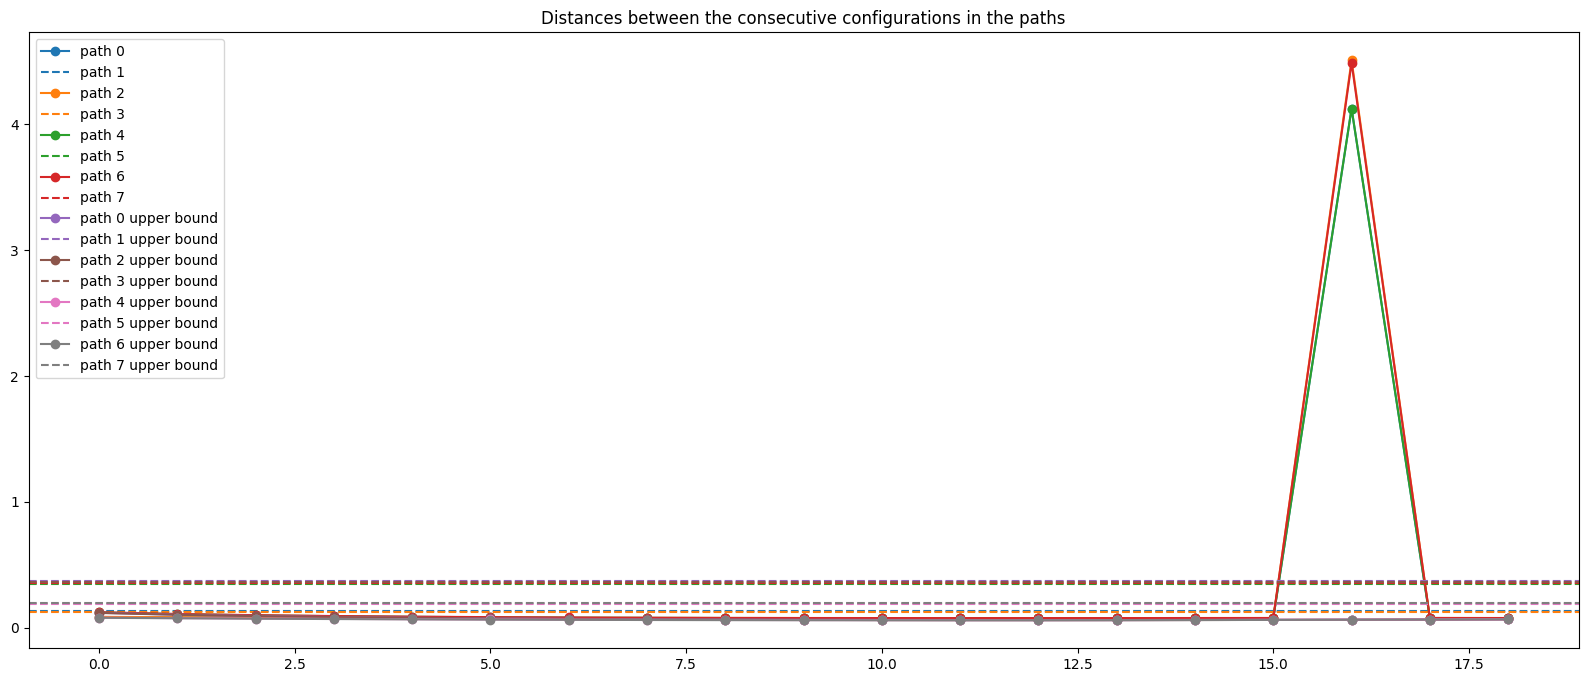

In [22]:
import matplotlib
import matplotlib.pyplot as plt
from airo_drake import calculate_joint_path_outlier_threshold

path_distances = [np.linalg.norm(np.diff(path, axis=0), axis=1) for path in paths]
thresholds = [calculate_joint_path_outlier_threshold(distances) for distances in path_distances]

colors = matplotlib.colormaps["tab10"].colors[:len(paths)]
plt.figure(figsize=(20, 8))
plt.title("Distances between the consecutive configurations in the paths")
for distances, threshold, color in zip(path_distances, thresholds, colors):
    plt.plot(distances, marker="o", color=color)
    plt.axhline(y=threshold, color=color, linestyle='--')
plt.legend([f"path {i}" for i in range(len(paths))] + [f"path {i} upper bound" for i in range(len(paths))])
plt.show()

In [23]:
from airo_drake import joint_path_has_large_jumps

for i, path in enumerate(paths):
    has_jumps = joint_path_has_large_jumps(path)

    distances = np.linalg.norm(np.diff(path, axis=0), axis=1)
    threshold = calculate_joint_path_outlier_threshold(distances)
    jumps = np.where(distances > threshold)[0]

    emoji = "🦘" if has_jumps else "✅"
    print(f"path {i}: {emoji} {jumps}")



path 0: 🦘 [16]
path 1: 🦘 [16]
path 2: 🦘 [16]
path 3: 🦘 [16]
path 4: ✅ []
path 5: ✅ []
path 6: ✅ []
path 7: ✅ []


In [24]:
paths_without_jumps = [path for path in paths if not joint_path_has_large_jumps(path)]

for path in paths_without_jumps:
    print(path_collisions_as_emojis(collision_checker.CheckConfigsCollisionFree(path)))

✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
✅✅✅✅✅✅✅✅💥💥💥💥💥💥💥💥💥💥💥💥
✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅


In [25]:
paths_with_collisions = [path for path in paths_without_jumps if not np.all(collision_checker.CheckConfigsCollisionFree(path))]

for path in paths_with_collisions:
    print(path_collisions_as_emojis(collision_checker.CheckConfigsCollisionFree(path)))

animate_joint_configurations(scene.meshcat, scene.robot_diagram, scene.arm_index, paths_with_collisions[0])

✅✅✅✅✅✅✅✅💥💥💥💥💥💥💥💥💥💥💥💥


In [26]:
paths_without_collisions = [path for path in paths_without_jumps if np.all(collision_checker.CheckConfigsCollisionFree(path))]

for path in paths_without_collisions:
    print(path_collisions_as_emojis(collision_checker.CheckConfigsCollisionFree(path)))

animate_joint_configurations(scene.meshcat, scene.robot_diagram, scene.arm_index, paths_without_collisions[0])

✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅


In [27]:
from airo_drake import time_parametrize_toppra


trajectories = [time_parametrize_toppra(scene.robot_diagram.plant(), path) for path in paths_without_collisions]
durations = [trajectory.end_time() for trajectory in trajectories]

print(durations)

[1.0821133056402081, 1.0821133056402081, 0.9808441751547153]


In [28]:
from airo_drake import animate_joint_trajectory

fastest_trajectory = trajectories[np.argmin(durations)]
animate_joint_trajectory(scene.meshcat, scene.robot_diagram, scene.arm_index, fastest_trajectory, context)

In [29]:
scene.meshcat.Delete("grasp_pose")
scene.meshcat.Delete("pregrasp_pose")
scene.meshcat.Delete("tcp_path")

### Use case two: Closing a Nepresso machine's lever ☕

In [30]:
# Colors
from pydrake.geometry import Rgba
yellow = Rgba(1, 1, 0, 0.5)
cyan = Rgba(0, 1, 1, 0.5)
magenta = Rgba(1, 0, 1, 0.5)


lever_axis_middle = np.array([0.35, 0.0, 0.2])
lever_axis_direction = np.array([0, -1, 0])

In [31]:
from airo_drake.visualization.arrow import visualize_arrow
from pydrake.geometry import Sphere, Rgba
from pydrake.math import RigidTransform


level_axis_start = lever_axis_middle - 0.1 * lever_axis_direction
level_axis_end = lever_axis_middle + 0.1 * lever_axis_direction
visualize_arrow(meshcat, "lever", level_axis_start, end=level_axis_end)


meshcat.SetTransform(f"lever/middle", RigidTransform(p=lever_axis_middle))
meshcat.SetObject(f"lever/middle", Sphere(0.02), yellow)

In [32]:
lever_length = 0.15
lever_tip_opened = lever_axis_middle + lever_length * np.array([0, 0, 1])

meshcat.SetTransform(f"lever/tip", RigidTransform(p=lever_tip_opened))
meshcat.SetObject(f"lever/tip", Sphere(0.01), cyan)

In [33]:
import numpy as np
from airo_typing import Vector3DType
from scipy.spatial.transform import Rotation

# TODO: this is temporarily copied from Linen until it's available on PyPI
def rotate_point(point: Vector3DType, center: Vector3DType, axis: Vector3DType, angle: float):
    """
    Rotate a point around an axis by a given angle.

    Args:
        point: The point to rotate.
        center: The center of the rotation.
        axis: The axis to rotate around, which will be normalized.
        angle: The angle in radians to rotate by.

    Returns:
        The rotated point.
    """
    unit_axis = axis / np.linalg.norm(axis)
    rotation = Rotation.from_rotvec(angle * unit_axis)
    return center + rotation.apply(point - center)


lever_tip_opened, rotate_point(lever_tip_opened, lever_axis_middle, lever_axis_direction, 0.03)

(array([0.35, 0.  , 0.35]), array([0.34550067, 0.        , 0.34993251]))

In [34]:
level_tip_path = []

max_angle = np.deg2rad(90)
for angle in np.linspace(0, max_angle, 20):
    tip_position_rotated = rotate_point(lever_tip_opened, lever_axis_middle, lever_axis_direction, angle)
    level_tip_path.append(tip_position_rotated)


for i, tip_position in enumerate(level_tip_path):
    meshcat.SetTransform(f"lever/tip_position_{i}", RigidTransform(p=tip_position))
    meshcat.SetObject(f"lever/tip_position_{i}", Sphere(0.005), magenta)

In [35]:
X = np.array([-1.0, 0.0, 0.0])
Y = np.array([0.0, 1.0, 0.0])
Z = np.array([0.0, 0.0, -1.0])
top_down_orientation = np.column_stack([X, Y, Z])

tcp_path_lever = []

for tip_position in level_tip_path:
    pose = np.identity(4)
    pose[0:3, 3] = tip_position
    pose[0:3, 0:3] = top_down_orientation
    tcp_path_lever.append(pose)

for i, tcp_pose in enumerate(tcp_path_lever):
    visualize_frame(scene.meshcat, f"tcp_path_lever/pose_{i}", tcp_pose, length=0.05, opacity=0.1)

In [36]:
path_joints_solutions = []

for tcp_pose in tcp_path_lever:
    joint_solutions = ur5e.inverse_kinematics_with_tcp(tcp_pose, tcp_transform)
    path_joints_solutions.append(np.array(joint_solutions).squeeze())

paths = create_paths_from_closest_solutions(path_joints_solutions)
paths_without_jumps = [path for path in paths if not joint_path_has_large_jumps(path)]

for path in paths_without_jumps:
    print(path_collisions_as_emojis(collision_checker.CheckConfigsCollisionFree(path)))

✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
✅✅✅✅✅✅✅✅✅✅✅💥💥💥💥💥💥💥💥💥
✅✅✅✅✅✅✅✅✅✅✅💥💥💥💥💥💥💥💥💥
✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅


In [37]:
paths_with_collisions = [path for path in paths_without_jumps if not np.all(collision_checker.CheckConfigsCollisionFree(path))]

animate_joint_configurations(scene.meshcat, scene.robot_diagram, scene.arm_index, paths_with_collisions[0])

In [38]:
paths_without_collisions = [path for path in paths_without_jumps if np.all(collision_checker.CheckConfigsCollisionFree(path))]

for path in paths_without_collisions:
    print(path_collisions_as_emojis(collision_checker.CheckConfigsCollisionFree(path)))

✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅


In [39]:
trajectories = [time_parametrize_toppra(scene.robot_diagram.plant(), path, joint_acceleration_limit=1.0) for path in paths_without_collisions]
durations = [trajectory.end_time() for trajectory in trajectories]

print(durations)

[1.6488317327683064, 1.5839720500574017, 1.583972050057404, 1.648831732768306]


In [40]:
fastest_trajectory = trajectories[np.argmin(durations)]
animate_joint_trajectory(scene.meshcat, scene.robot_diagram, scene.arm_index, fastest_trajectory, context)

## Allowing collisions between bodies 🏳️

It is possible to allow collisions between certain bodies. Just for this example, let's allow collisions between the ur5e and the floor.

In [41]:
arm_body_indices = plant.GetBodyIndices(arm_index)
floor_body_indices = plant.GetBodyIndices(floor_index)

import itertools
body_combinations = itertools.product(arm_body_indices, floor_body_indices)

Let's go to a configuration where only the arm and the floor collide.

In [48]:
joints_table_collision = np.deg2rad([0, 45, 0, 0, 0, 0])
print_robot_collisions()
collision_checker.CheckConfigCollisionFree(joints_table_collision)

Body ur5e::base_link_inertia is colliding with body floor::base_link (type: environment)
Body ur5e::base_link_inertia is colliding with body floor::base_link (type: environment)
Body ur5e::upper_arm_link is colliding with body floor::base_link (type: environment)
Body ur5e::upper_arm_link is colliding with body floor::base_link (type: environment)
Body ur5e::forearm_link is colliding with body floor::base_link (type: environment)
Body ur5e::forearm_link is colliding with body floor::base_link (type: environment)


False

In [49]:
plant.SetPositions(plant_context, scene.arm_index, joints_table_collision)
scene.robot_diagram.ForcedPublish(context)

In [50]:
for body_index_arm, body_index_floor in body_combinations:
    collision_checker.SetCollisionFilteredBetween(body_index_arm, body_index_floor, True)

We should now see no collisions.

In [51]:
print_robot_collisions()
collision_checker.CheckConfigCollisionFree(joints_table_collision)

Body ur5e::base_link_inertia is colliding with body floor::base_link (type: environment)
Body ur5e::base_link_inertia is colliding with body floor::base_link (type: environment)
Body ur5e::upper_arm_link is colliding with body floor::base_link (type: environment)
Body ur5e::upper_arm_link is colliding with body floor::base_link (type: environment)
Body ur5e::forearm_link is colliding with body floor::base_link (type: environment)
Body ur5e::forearm_link is colliding with body floor::base_link (type: environment)


False

We can re-enable collisions equally as easily.

In [52]:
body_combinations = itertools.product(arm_body_indices, floor_body_indices)  # Repopulate the generator.
for body_index_arm, body_index_floor in body_combinations:
    collision_checker.SetCollisionFilteredBetween(body_index_arm, body_index_floor, False)

In [53]:
print_robot_collisions()
collision_checker.CheckConfigCollisionFree(joints_table_collision)

Body ur5e::base_link_inertia is colliding with body floor::base_link (type: environment)
Body ur5e::base_link_inertia is colliding with body floor::base_link (type: environment)
Body ur5e::upper_arm_link is colliding with body floor::base_link (type: environment)
Body ur5e::upper_arm_link is colliding with body floor::base_link (type: environment)
Body ur5e::forearm_link is colliding with body floor::base_link (type: environment)
Body ur5e::forearm_link is colliding with body floor::base_link (type: environment)


False